In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
%cd /home/volkan/Repos/multi-tier/
from data_analysis.helpers import *

vip2 delay: 18413.829175732764
vipsbw delay: 18259.099526590086
vipsbw2 delay: 76155.74687962196


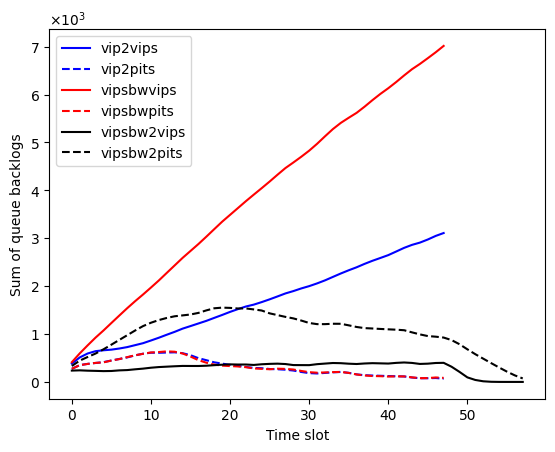

In [29]:
experiment_name = "test"
topology = "abilene"
config_path = "sim_configs/sample_config.json"
#config_path = "sim_configs/" + experiment_name + "_config.json"
test_config = getTestConfig(config_path)
db_path = "sim_outputs/" + experiment_name + "_" + topology + "_db.json"
db = getJsonDb(db_path)

request_rate = 10
request_dist_param = 0.75
case_filters = [
    ("request_rate", request_rate, None),
    ("request_dist_param", request_dist_param, None),
]

param_list = simConfigToParamSets(test_config)
param_list = filterParamList(param_list, case_filters)
fig, ax = plt.subplots()
for cache_pol in ["vip2", "vipsbw", "vipsbw2"]:
    filters = [("cache_pol", cache_pol, None)]
    pol_param_list = filterParamList(param_list, filters)
    assert len(pol_param_list) == 1
    param_hash = str(hash(pol_param_list[0]))
    vips = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "vip_count_sum",
    )
    pits = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "pit_count_sum",
    )
    delay = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "delay",
    )
    window_size = 3
    vip_moving_avg = np.convolve(vips, np.ones(window_size) / window_size, mode="valid")
    pit_moving_avg = np.convolve(pits, np.ones(window_size) / window_size, mode="valid")
    if cache_pol == "vip2":
        drawstyle = "b"
    if cache_pol == "vipsbw":
        drawstyle = "r"
    if cache_pol == "vipsbw2":
        drawstyle = "k"
    ax.plot(range(len(vip_moving_avg)), vip_moving_avg, "-"+drawstyle, label=cache_pol+"vips")
    ax.plot(range(len(pit_moving_avg)), pit_moving_avg, "--"+drawstyle, label=cache_pol+"pits")
    print(cache_pol + " delay: " + str(delay))

#ax.set_xlim([0, 95])
ax.set_xlabel("Time slot")
ax.set_ylabel("Sum of queue backlogs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
ax.legend()
#ax.legend(["VIP queues", "PIT queues", "VIP queues w/ cache bw constraint", "PIT queues w/ cache bw constraint"])
#fig_name = "_".join(tuple(map(str,(experiment_name,topology,request_rate,request_dist_param))))
#fig_path = "../sim_outputs/" + fig_name + ".pdf"
#plt.savefig(fig_path)
#plt.show()

In [ ]:
df = pd.read_json('/home/volkan/Repos/multi-tier/sim_outputs/sample_abilene_db.json')
column_dfs = [item[1] for item in df.items()]

fig = plt.figure()

labels = []

for column_df in column_dfs:
    if 'vip_count_sum' not in column_df['data']['0']:
        continue
    label_suffix = str(column_df['parameters']['pen_weight'])
    num_slots = int(column_df['data']['sim_time'])
    vip_count_acc = np.zeros(num_slots)
    pit_count_acc = np.zeros(num_slots)
    for key in range(11):
        if 'vip_count_sum' in column_df['data'][str(key)]:
            vip_count_acc += column_df['data'][str(key)]['vip_count_sum']
            pit_count_acc += column_df['data'][str(key)]['pit_count_sum']
    window_size = 3
    vip_moving_avg = np.convolve(vip_count_acc, np.ones(window_size)/window_size, mode='valid')
    plt.plot(vip_moving_avg, label="vip_sum:pw_"+label_suffix)
    labels.append("vip_sum:pw_"+label_suffix)
    pit_moving_avg = np.convolve(pit_count_acc, np.ones(window_size)/window_size, mode='valid')
    plt.plot(pit_moving_avg, label="pit_sum:pw_"+label_suffix)
    labels.append("pit_sum:pw_"+label_suffix)
    
plt.legend(labels=labels,loc='upper left')
plt.show()
